[![View notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Pierchala_et_al_2022/fig_3.ipynb)
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Pierchala_et_al_2022/fig_3.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Pierchala_et_al_2022/fig_3.ipynb)

### based on Fig. 3 from Pierchala et al. 2020 (Geochim. Cosmochim. Acta) "_Quantiﬁcation the diﬀusion-induced fractionation of $^{1}H_{2} ^{17}O$ isotopologue in air accompanying the process of water evaporation_" (https://doi.org/10.1016/j.gca.2022.01.020)

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [7]:
import numpy as np
from matplotlib import pyplot
from PySDM import Formulae
from PySDM.physics import si, in_unit
from PySDM_examples.Pierchala_et_al_2022.commons import deltas_0_SMOW, TABLE_2
from open_atmos_jupyter_utils import show_plot

In [3]:
formulae = Formulae(
    isotope_equilibrium_fractionation_factors='PierchalaEtAl2022',
    isotope_meteoric_water_line_excess='PierchalaEtAl2022',
    isotope_ratio_evolution='RayleighDistillation'
)
const = formulae.constants

# fitted kinetic enrichment coeffs from Table 2
eps_kin = TABLE_2['eps_kin']

F = np.linspace(1, .3)
T = (const.T0 + 20.36) * si.K

In [4]:
def E(F_arg, alpha_eq, alpha_kin):
    """ eq. 5 in Pierchala et al. 2022 """
    return formulae.isotope_ratio_evolution.R_over_R0(F_arg, 1/(alpha_eq * alpha_kin)) - 1

In [5]:
alphas = formulae.isotope_equilibrium_fractionation_factors

alpha_l_18O = alphas.alpha_l_18O(T=T)
alpha_l_2H = alphas.alpha_l_2H(T=T)
alpha_l_17O = alphas.alpha_l_17O(np.nan, alpha_l_18O=alpha_l_18O)

excess = formulae.isotope_meteoric_water_line_excess

deltas = {}
enrichments = {}
for a_eq, eps_key in (
    (alpha_l_18O, '18O'), 
    (alpha_l_2H, '2H'), 
    (alpha_l_17O, '17O')
):
    enrichments[eps_key] = E(F, alpha_eq=a_eq, alpha_kin=1 + eps_kin[eps_key])
    deltas[eps_key] = formulae.trivia.isotopic_enrichment_to_delta_SMOW(
        E=enrichments[eps_key],
        delta_0_SMOW=deltas_0_SMOW[eps_key],
    )

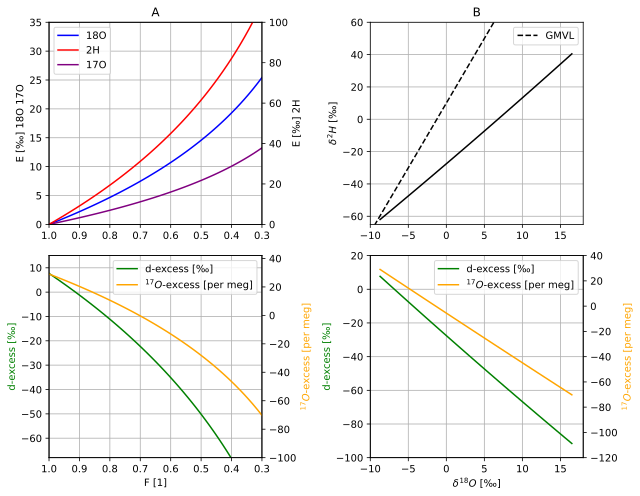

HTML(value="<a href='./fig_3.pdf' target='_blank'>./fig_3.pdf</a><br>")

In [6]:
_, axs = pyplot.subplots(2, 2, figsize=(9, 7), tight_layout=True)

axs[0, 0].set_title('A')
axs[0, 1].set_title('B')
axs[0, 0].sharex(axs[1, 0])
axs[0, 1].sharex(axs[1, 1])

alpha_axl = axs[0, 0]
alpha_axr = alpha_axl.twinx()
 
plots = []
for color, eps_key, ax in (
    ('blue', '18O', alpha_axl), 
    ('red', '2H', alpha_axr), 
    ('purple', '17O', alpha_axl)
):
    plots += ax.plot(
        F,
        in_unit(enrichments[eps_key], const.PER_MILLE),
        label=eps_key,
        color=color
    )
    if ax.get_ylabel() == "":
        ax.set_ylabel("E [‰]")
    ax.set_ylabel(ax.get_ylabel() + " " + eps_key)
pyplot.legend(plots, [l.get_label() for l in plots])
pyplot.xlim(*F[[0, -1]])
alpha_axl.grid(None)
alpha_axl.set_ylim(0, 35)
alpha_axr.set_ylim(0, 100)

excess_axl = axs[1, 0]
excess_axr = excess_axl.twinx()
plots = []
for color, fun, args, mult, label, ax in (
    ('green', 'excess_d', (deltas['2H'], deltas['18O']), const.PER_MILLE, "d-excess [‰]", excess_axl),
    ('orange', 'excess_17O', (deltas['17O'], deltas['18O']), const.PER_MEG, "$^{17}O$-excess [per meg]", excess_axr),
):
    plots += ax.plot(
        F,
        in_unit(getattr(excess, fun)(*args), mult),
        color=color,
        label=label
    )
    ax.set_ylabel(label, color=color)
pyplot.legend(plots, [l.get_label() for l in plots])
excess_axl.grid(None)
excess_axl.set_ylim(-68, 15)
excess_axr.set_ylim(-100, 42)

axs[1, 0].set_xlabel("F [1]")
axs[1, 0].set_xticks(np.linspace(*F[[0,-1]], 8))


axs[0, 1].set_ylabel("$δ^2H$ [‰]")
axs[0, 1].grid()
axs[0, 1].set_ylim(-65, 60)
axs[0, 1].set_xlim(-10, 18)
axs[0, 1].set_xticks(np.linspace(-10, 15, 6))

x = np.linspace(-10e-3, 10e-3, 100)
axs[0, 1].plot(
    in_unit(x, const.PER_MILLE),
    in_unit(x * const.CRAIG_1961_SLOPE_COEFF + const.CRAIG_1961_INTERCEPT_COEFF, const.PER_MILLE),
    color='black',
    linestyle='--',
    label="GMVL"
)
axs[0, 1].plot(
    in_unit(deltas["18O"], const.PER_MILLE),
    in_unit(deltas["2H"], const.PER_MILLE),
    color='black'
)
axs[0, 1].legend()

excess_axl = axs[1, 1]
excess_axr = excess_axl.twinx()
plots = []
for color, fun, args, mult, label, ax in (
    ('green', 'excess_d', (deltas['2H'], deltas['18O']), const.PER_MILLE, "d-excess [‰]", excess_axl),
    ('orange', 'excess_17O', (deltas['17O'], deltas['18O']), const.PER_MEG, "$^{17}O$-excess [per meg]", excess_axr),
):
    plots += ax.plot(
        in_unit(deltas["18O"], const.PER_MILLE),
        in_unit(getattr(excess, fun)(*args), mult),
        color=color,
        label=label
    )
    ax.set_ylabel(label, color=color)
pyplot.legend(plots, [l.get_label() for l in plots])
excess_axl.grid(None)
excess_axl.set_ylim(-100, 20)
excess_axr.set_ylim(-120, 40)

axs[1, 1].set_xlabel("$δ^{18}O$ [‰]")

show_plot("fig_3.pdf")